In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from utils import accuracy
from get_dataset import get_cifar100_data_loaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CIFAR-100 数据加载器
cifar100_train_loader, cifar100_test_loader = get_cifar100_data_loaders(batch_size=256)

def finetune_resnet18(model, train_loader, test_loader, epochs=8, lr=0.0005, weight_decay=0.0, log_interval=20):
    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Linear(512, 100)
    for param in model.fc.parameters():
        param.requires_grad = True
        
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    top1_train_accuracy_list = []
    top1_accuracy_list = []
    top5_accuracy_list = []
    iteration_list = []
    train_loss_list = []
    test_loss_list = []

    iteration = 0
    top1_train_accuracy = 0
    train_loss = 0
    last_log_iter = 0
    for epoch in range(epochs):
        model.train()

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            top1 = accuracy(logits, y_batch, topk=(1,))
            top1_train_accuracy += top1[0]

            iteration += 1

            if iteration % log_interval == 0:
                # if iteration-last_log_iter < log_interval:
                #     last_log_iter = iteration
                #     continue
                top1_train_accuracy /= (iteration-last_log_iter)
                train_loss /= (iteration-last_log_iter)

                model.eval()
                top1_accuracy = 0
                top5_accuracy = 0
                test_loss = 0
                with torch.no_grad():
                    for x_batch, y_batch in test_loader:
                        x_batch = x_batch.to(device)
                        y_batch = y_batch.to(device)
                        logits = model(x_batch)
                        loss = criterion(logits, y_batch)
                        test_loss += loss.item()
                        top1, top5 = accuracy(logits, y_batch, topk=(1, 5))
                        top1_accuracy += top1[0]
                        top5_accuracy += top5[0]

                top1_accuracy /= len(test_loader)
                top5_accuracy /= len(test_loader)
                test_loss /= len(test_loader)

                top1_train_accuracy_list.append(top1_train_accuracy.item())
                top1_accuracy_list.append(top1_accuracy.item())
                top5_accuracy_list.append(top5_accuracy.item())
                train_loss_list.append(train_loss)
                test_loss_list.append(test_loss)
                iteration_list.append(iteration)
                
                print(f"Iteration {iteration}\tTop1 Train accuracy: {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 Test accuracy: {top5_accuracy.item()}\tTrain loss: {train_loss}\tTest loss: {test_loss}")

                # Reset train metrics
                top1_train_accuracy = 0
                train_loss = 0
                model.train()
                last_log_iter = iteration

    return top1_train_accuracy_list, top1_accuracy_list, top5_accuracy_list, train_loss_list, test_loss_list, iteration_list


#### 在 ImageNet 上使用监督学习预训练ResNet-18

In [2]:

# 加载ImageNet预训练的ResNet-18
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)

# 微调 ImageNet 预训练的 ResNet-18
imagenet_top1_train_accuracy, imagenet_top1_test_accuracy, imagenet_top5_test_accuracy, imagenet_train_loss, imagenet_test_loss, iteration_list = finetune_resnet18(
    imagenet_resnet18, cifar100_train_loader, cifar100_test_loader)


/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(

Iteration 20	Top1 Train accuracy: 1.953125	Top1 Test accuracy: 3.06640625	Top5 Test accuracy: 11.962890625	Train loss: 4.717248344421387	Test loss: 4.516067957878112
Iteration 40	Top1 Train accuracy: 5.41015625	Top1 Test accuracy: 7.578125	Top5 Test accuracy: 20.48828125	Train loss: 4.440269684791565	Test loss: 4.297230458259582
Iteration 60	Top1 Train accuracy: 8.65234375	Top1 Test accuracy: 10.458984375	Top5 Test accuracy: 27.060546875	Train loss: 4.206660461425781	Test loss: 4.115563297271729
Iteration 80	Top1 Train accuracy: 11.2109375	Top1 Test accuracy: 13.3203125	Top5 Test accuracy: 32.83203125	Train loss: 4.065842628479004	Test loss: 3.965588313341141
Iteration 100	Top1 Train accuracy: 13.3203125	Top1 Test accuracy: 14.716796875	Top5 Test accuracy: 35.732421875	Train loss: 3.9444706439971924	Test loss: 3.86356383562088
Iteration 120	Top1 Train accuracy: 15.9375	Top1 Test accuracy: 15.76171875	Top5 Test accuracy: 38.65234375	Train loss: 3.8221659064292908	Test loss: 3.7870724856

#### 在 Tiny ImageNet 上通过自监督学习训练 ResNet-18

In [3]:
# 加载在 Tiny ImageNet 上通过自监督学习训练的 ResNet-18
checkpoint_path = '/root/Lab3-1/logs/simclr_TIN_lr0.001_wd0_temp0.07_bt512_e500/checkpoint_0400.pth.tar'
ssl_resnet18 = torchvision.models.resnet18(pretrained=False)
ssl_resnet18.fc = torch.nn.Linear(512, 100)  
checkpoint = torch.load(checkpoint_path, map_location=device)

# 加载自监督预训练权重
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    if k.startswith('backbone.') and not k.startswith('backbone.fc'):
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]
ssl_resnet18.load_state_dict(state_dict, strict=False)

# 微调通过自监督学习训练的 ResNet-18
ssl_top1_train_accuracy, ssl_top1_test_accuracy, ssl_top5_test_accuracy, ssl_train_loss, ssl_test_loss, _ = finetune_resnet18(
    ssl_resnet18, cifar100_train_loader, cifar100_test_loader)

/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Iteration 20	Top1 Train accuracy: 3.0859375	Top1 Test accuracy: 6.23046875	Top5 Test accuracy: 21.171875	Train loss: 4.557574844360351	Test loss: 4.271985900402069
Iteration 40	Top1 Train accuracy: 9.296875	Top1 Test accuracy: 12.724609375	Top5 Test accuracy: 33.408203125	Train loss: 4.1055619597435	Test loss: 3.9143237471580505
Iteration 60	Top1 Train accuracy: 14.609375	Top1 Test accuracy: 16.2890625	Top5 Test accuracy: 40.625	Train loss: 3.8102097272872926	Test loss: 3.689022260904312
Iteration 80	Top1 Train accuracy: 17.16796875	Top1 Test accuracy: 18.896484375	Top5 Test accuracy: 44.5703125	Train loss: 3.6334011912345887	Test loss: 3.530577915906906
Iteration 100	Top1 Train accuracy: 18.65234375	Top1 Test accuracy: 20.60546875	Top5 Test accuracy: 46.54296875	Train loss: 3.491433894634247	Test loss: 3.427312195301056
Iteration 120	Top1 Train accuracy: 20.9765625	Top1 Test accuracy: 21.54296875	Top5 Test accuracy: 48.30078125	Train loss: 3.390097415447235	Test loss: 3.34551559090614

Iteration 300	Top1 Train accuracy: 26.4453125	Top1 Test accuracy: 26.455078125	Top5 Test accuracy: 54.21875	Train loss: 3.0273558497428894	Test loss: 3.0644122123718263
Iteration 320	Top1 Train accuracy: 28.22265625	Top1 Test accuracy: 26.982421875	Top5 Test accuracy: 54.619140625	Train loss: 2.9838091135025024	Test loss: 3.043734663724899
Iteration 340	Top1 Train accuracy: 27.1875	Top1 Test accuracy: 26.748046875	Top5 Test accuracy: 54.970703125	Train loss: 3.014138126373291	Test loss: 3.0341450452804564
Iteration 360	Top1 Train accuracy: 26.9921875	Top1 Test accuracy: 27.392578125	Top5 Test accuracy: 55.166015625	Train loss: 2.9965378403663636	Test loss: 3.020188331604004
Iteration 380	Top1 Train accuracy: 28.14453125	Top1 Test accuracy: 27.08984375	Top5 Test accuracy: 55.0	Train loss: 2.9809478878974915	Test loss: 3.0147271156311035
Iteration 400	Top1 Train accuracy: 28.63671875	Top1 Test accuracy: 27.294921875	Top5 Test accuracy: 55.703125	Train loss: 2.9568625569343565	Test loss: 

#### 在 CIFAR-100 上使用监督学习训练 ResNet-18

In [4]:
# import torch
# import torchvision

# # 加载在 CIFAR-100 上训练的 ResNet-18
# checkpoint_path = '/root/Lab3-2/resnet18_Adam_bt-512_lr0.0005_wd-0_e200.pth'
# CIFAR100_resnet18 = torchvision.models.resnet18(pretrained=False)
# CIFAR100_resnet18.fc = torch.nn.Linear(512, 100)

# # 加载权重并去除前缀
# checkpoint = torch.load(checkpoint_path)
# new_checkpoint = {}
# for k, v in checkpoint.items():
#     name = k[6:]  # 去除 'model.' 前缀
#     new_checkpoint[name] = v

# CIFAR100_resnet18.load_state_dict(new_checkpoint)

# # 微调通过自监督学习训练的 ResNet-18
# CIFAR100_top1_train_accuracy, CIFAR100_top1_test_accuracy, CIFAR100_top5_test_accuracy, CIFAR100_train_loss, CIFAR100_test_loss, _ = finetune_resnet18(
#     CIFAR100_resnet18, cifar100_train_loader, cifar100_test_loader)


#### 在 CIFAR10 上通过自监督学习训练 ResNet-18

In [5]:
# 加载在 CIFAR10 上通过自监督学习训练的 ResNet-18
checkpoint_path = '/root/Lab3-1/logs/simclr_C10_lr0.001_wd0_temp0.07_bt512_e400/checkpoint_0400.pth.tar'
CIFAR10_resnet18 = torchvision.models.resnet18(pretrained=False)
CIFAR10_resnet18.fc = torch.nn.Linear(512, 100)  
checkpoint = torch.load(checkpoint_path, map_location=device)

# 加载自监督预训练权重
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    if k.startswith('backbone.') and not k.startswith('backbone.fc'):
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]
CIFAR10_resnet18.load_state_dict(state_dict, strict=False)

# 微调通过自监督学习训练的 ResNet-18
CIFAR10_top1_train_accuracy, CIFAR10_top1_test_accuracy, CIFAR10_top5_test_accuracy, CIFAR10_train_loss, CIFAR10_test_loss, _ = finetune_resnet18(
    CIFAR10_resnet18, cifar100_train_loader, cifar100_test_loader)

Iteration 20	Top1 Train accuracy: 2.63671875	Top1 Test accuracy: 4.84375	Top5 Test accuracy: 17.8515625	Train loss: 4.594123125076294	Test loss: 4.3891183018684385
Iteration 40	Top1 Train accuracy: 7.4609375	Top1 Test accuracy: 10.078125	Top5 Test accuracy: 28.037109375	Train loss: 4.255154490470886	Test loss: 4.126303386688233
Iteration 60	Top1 Train accuracy: 12.421875	Top1 Test accuracy: 13.095703125	Top5 Test accuracy: 33.837890625	Train loss: 4.011190903186798	Test loss: 3.947522896528244
Iteration 80	Top1 Train accuracy: 14.19921875	Top1 Test accuracy: 15.1171875	Top5 Test accuracy: 37.12890625	Train loss: 3.8845078349113464	Test loss: 3.818401885032654
Iteration 100	Top1 Train accuracy: 15.60546875	Top1 Test accuracy: 16.533203125	Top5 Test accuracy: 39.04296875	Train loss: 3.761017405986786	Test loss: 3.731672477722168
Iteration 120	Top1 Train accuracy: 17.265625	Top1 Test accuracy: 17.333984375	Top5 Test accuracy: 40.439453125	Train loss: 3.6671998262405396	Test loss: 3.660157

In [6]:
# # 绘制 Accuracy 图
# plt.figure(figsize=(16, 9))
# plt.rcParams.update({'font.size': 14})
# plt.title('CIFAR100 Accuracy Comparison')
# plt.plot(iteration_list, imagenet_top1_train_accuracy, c='b', linestyle='--')
# plt.plot(iteration_list, imagenet_top1_test_accuracy, c='g', linestyle='--')
# plt.plot(iteration_list, ssl_top1_train_accuracy, c='b')
# plt.plot(iteration_list, ssl_top1_test_accuracy, c='g')
# plt.plot(iteration_list, CIFAR100_top1_train_accuracy, c='b', linestyle=':')
# plt.plot(iteration_list, CIFAR100_top1_test_accuracy, c='g', linestyle=':')
# plt.legend(['ImageNet Train Accuracy', 'ImageNet Top 1 Test Accuracy',
#             'SSL Train Accuracy', 'SSL Top 1 Test Accuracy',
#             'CIFAR100 Train Accuracy', 'CIFAR100 Top 1 Test Accuracy'])
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.show()

# # 绘制 Loss 图
# plt.figure(figsize=(16, 9))
# plt.rcParams.update({'font.size': 14})
# plt.title('CIFAR100 Loss Comparison')
# plt.plot(iteration_list, imagenet_train_loss, c='b', linestyle='--')
# plt.plot(iteration_list, imagenet_test_loss, c='g', linestyle='--')
# plt.plot(iteration_list, ssl_train_loss, c='b')
# plt.plot(iteration_list, ssl_test_loss, c='g')
# plt.plot(iteration_list, CIFAR100_train_loss, c='b', linestyle=':')
# plt.plot(iteration_list, CIFAR100_test_loss, c='g', linestyle=':')
# plt.legend(['ImageNet Train Loss', 'ImageNet Test Loss',
#             'SSL Train Loss', 'SSL Test Loss',
#             'CIFAR100 Train Loss', 'CIFAR100 Test Loss'])
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.show()


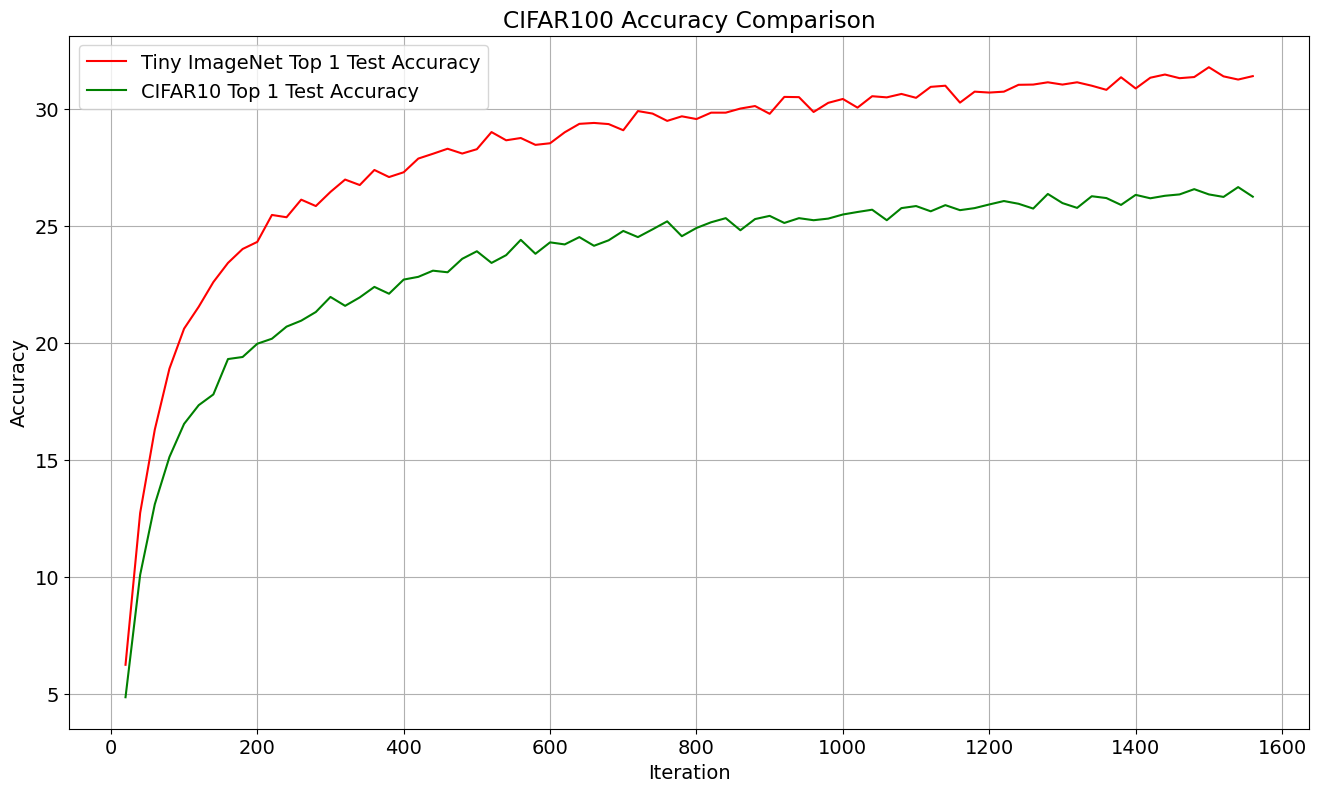

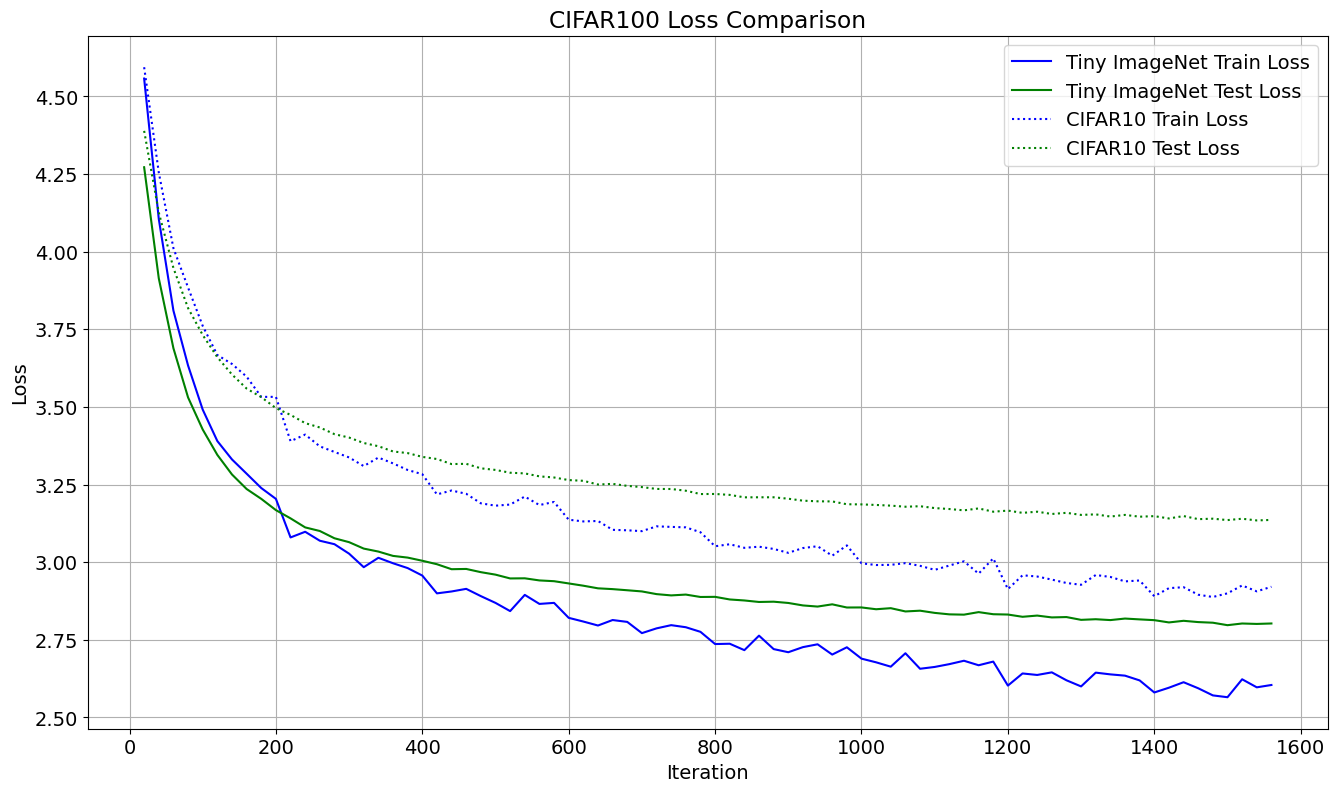

In [11]:
# 绘制 Accuracy 图
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Accuracy Comparison')

plt.plot(iteration_list, ssl_top1_test_accuracy, c='r')
plt.plot(iteration_list, CIFAR10_top1_test_accuracy, c='g')
plt.legend([
            'Tiny ImageNet Top 1 Test Accuracy',
            'CIFAR10 Top 1 Test Accuracy'])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# 绘制 Loss 图
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Loss Comparison')
plt.plot(iteration_list, ssl_train_loss, c='b')
plt.plot(iteration_list, ssl_test_loss, c='g')
plt.plot(iteration_list, CIFAR10_train_loss, c='b', linestyle=':')
plt.plot(iteration_list, CIFAR10_test_loss, c='g', linestyle=':')
plt.legend([
            'Tiny ImageNet Train Loss', 'Tiny ImageNet Test Loss',
            'CIFAR10 Train Loss', 'CIFAR10 Test Loss'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
